In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDERNAME = 'cs231/assignments/2023/assignment1_colab/assignment1'
assert FOLDERNAME is not None, "[!] Enter folder name."

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [ ]:
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/cs231/assignments/2023/assignment1_colab/assignment1/cs231n/datasets
/content/drive/My Drive/cs231/assignments/2023/assignment1_colab/assignment1


k-Nearest Neighbor

In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # -> Default plot size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [ ]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
try:
  del X_train, y_train
  del X_test,y_test
  print("Clear previously loaded data.")
except:
  pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


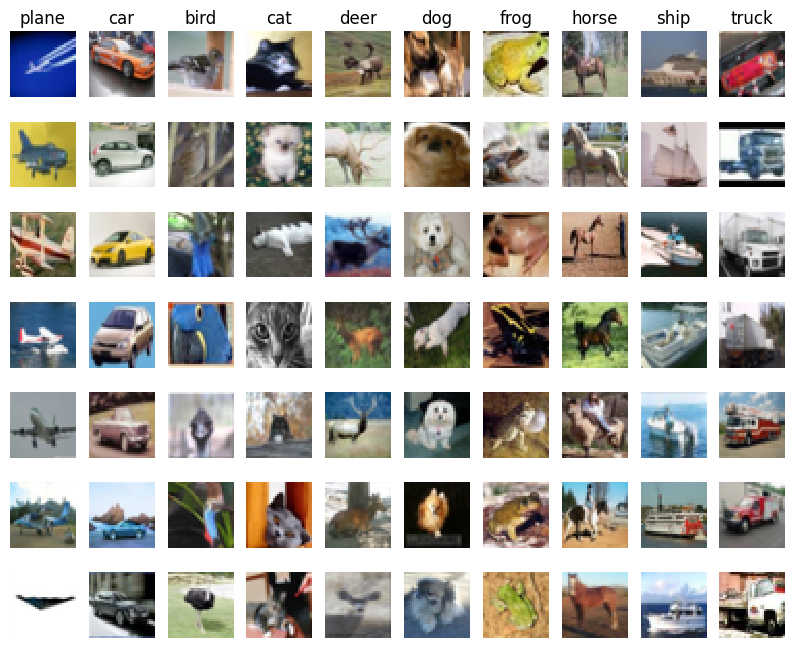

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

samples_per_class = 7
for y, cls in enumerate(classes):
  idxs = np.flatnonzero(y_train == y)
  idxs = np.random.choice(idxs, samples_per_class, replace = False)
  for i, idx in enumerate(idxs):
    plt_idx = i*num_classes + y + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()


In [ ]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print(X_train.shape,X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs231n.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()

classifier.train(X_train, y_train)

dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


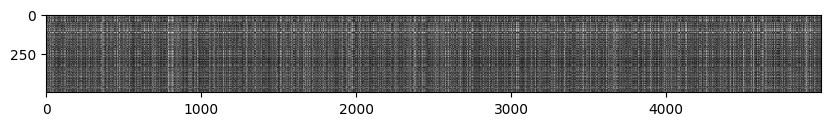

In [ ]:
plt.imshow(dists, interpolation = 'none')
plt.show()

In [ ]:
y_test_pred = classifier.predict_labels(dists, k = 1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct)/num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


In [ ]:
y_test_pred = classifier.predict_labels(dists, k = 5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct)/num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


In [ ]:
dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord = 'fro')

print('One loop difference was: %f' % (difference,))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Distances are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [27]:
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord = 'fro')
print('Difference was %f' %(difference,) )
if difference < 0.001:
  print('GOod')
else: print('Goodnt')

Difference was 0.000000
GOod


In [28]:
def time_function(f, *args):
  import time
  tic =time.time()
  f(*args)
  toc = time.time()
  return toc - tic

In [30]:
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop time: %f' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop: %f' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop: %f' % no_loop_time)


Two loop time: 29.088460
One loop: 55.895524
No loop: 1.039038


In [32]:
num_folds = 5
k_choices = [1,3,5,8,10,12,15,20,50,100]

X_train_folds = []
y_train_folds = []

if num_training/num_folds % num_folds != 0.0:
  raise ValueError('Number of training examples not evenly divisible by number of folds')

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
  k_to_accuracies[k] = []

for idx in range(num_folds):
  X_train_set = np.concatenate((*X_train_folds[:idx], *X_train_folds[idx+1:]), axis = 0)
  y_train_set = np.concatenate((*y_train_folds[:idx], *y_train_folds[idx+1:]), axis = 0)

  X_validation_set = X_train_folds[idx]
  y_validation_set = y_train_folds[idx]
  num_validation_set = X_validation_set.shape[0]
  classifier = KNearestNeighbor()
  classifier.train(X_train_set, y_train_set)

  dists_validate = classifier.compute_distances_no_loops(X_validation_set)

  for k in k_choices:
    y_validation_pred = classifier.predict_labels(dists_validate, k = k)
    accuracy = (float(np.sum(np.equal(y_validation_pred, y_validation_set)))/num_validation_set)
    k_to_accuracies[k].append(accuracy)

for k in sorted(k_to_accuracies):
  for accuracy in k_to_accuracies[k]:
    print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.102000
k = 1, accuracy = 0.100000
k = 1, accuracy = 0.097000
k = 1, accuracy = 0.097000
k = 1, accuracy = 0.109000
k = 3, accuracy = 0.102000
k = 3, accuracy = 0.100000
k = 3, accuracy = 0.097000
k = 3, accuracy = 0.097000
k = 3, accuracy = 0.109000
k = 5, accuracy = 0.102000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.097000
k = 5, accuracy = 0.097000
k = 5, accuracy = 0.109000
k = 8, accuracy = 0.102000
k = 8, accuracy = 0.100000
k = 8, accuracy = 0.097000
k = 8, accuracy = 0.097000
k = 8, accuracy = 0.109000
k = 10, accuracy = 0.102000
k = 10, accuracy = 0.100000
k = 10, accuracy = 0.097000
k = 10, accuracy = 0.097000
k = 10, accuracy = 0.109000
k = 12, accuracy = 0.102000
k = 12, accuracy = 0.100000
k = 12, accuracy = 0.097000
k = 12, accuracy = 0.097000
k = 12, accuracy = 0.109000
k = 15, accuracy = 0.102000
k = 15, accuracy = 0.100000
k = 15, accuracy = 0.097000
k = 15, accuracy = 0.097000
k = 15, accuracy = 0.109000
k = 20, accuracy = 0.102000
k = 20, accu

k = 1, average accuracy = 0.101000
k = 3, average accuracy = 0.101000
k = 5, average accuracy = 0.101000
k = 8, average accuracy = 0.101000
k = 10, average accuracy = 0.101000
k = 12, average accuracy = 0.101000
k = 15, average accuracy = 0.101000
k = 20, average accuracy = 0.101000
k = 50, average accuracy = 0.101000
k = 100, average accuracy = 0.101000


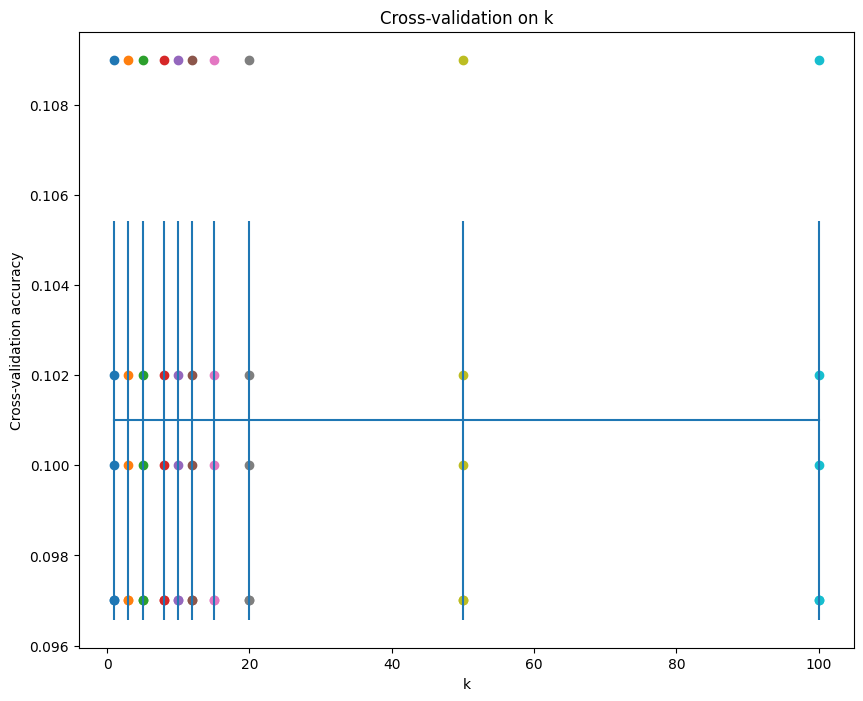

In [33]:
for k in k_choices:
  accuracies = k_to_accuracies[k]
  print('k = %d, average accuracy = %f' % (k, np.average(accuracies)))
  plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [34]:
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

y_test_pred = classifier.predict(X_test, k = best_k)


num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct)/num_test

print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000
